# Week 06 Lab: Single Particle Langevin Dynamics

## Student Name: YOUR NAME HERE

<img src="https://cdn.pixabay.com/photo/2014/03/26/17/28/sphere-298822_1280.jpg" width="300"/>

Today we're studying a very simple system: a single particle on a one-dimensional energy surface.  While this might not seem like the most exciting (or biologically-relevant) system, it is complex enough to demonstrate some essential principles of MD simulation (and even gain some insight into real biomolecular processes).

While there are many software packages that implement MD simulations, in this lab **we will be writing all of the code to do this in our Jupyter notebook!** In later weeks we will move on to use the OpenMM program to conduct biomolecular simulations, but for this week and the next we will get down and dirty implementing MD with functions we write ourselves.

## Forces

First let's write functions for the internal energy ($U(x)$) and the net force ($F(x) = -dU(x)/dx$).

We get to design our own energy function here and we will start with the following:

$$U(x) = (x-2)^4 + 2(x-2)^3 - 4(x-1.5)^2 + 8$$

Let's code it up and then see how it looks!

**Task:** Finish the following function:

In [1]:
def potential(x):
    U = None   # CORRECT THIS LINE
    return U

Now run the cell below to plot it on the range (-1,4):

Text(0, 0.5, 'U(x)')

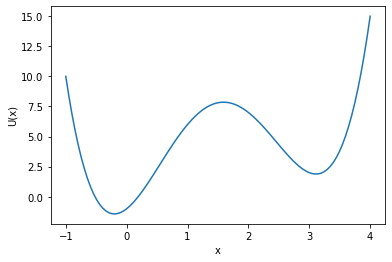

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x_vals = np.linspace(-1,4,100)

plt.plot(x_vals,potential(x_vals))
plt.xlabel("x")
plt.ylabel("U(x)")

You should see a double-well potential with the deepest well around $x=0$ and a secondary well at $x=3$.  

We often refer to these wells as **"local minima"**.  The $x=0$ well here is the **"global minimum"**.

**Task:** Make another function called `force` that takes in `x`, then computes and returns `-dU/dx`.  (Dust off those calculus skills!)  

This should automatically work both when `x` is a float and when `x` is a numpy array.

In [4]:
# your code here

In [6]:
# Confirm it is working with this test
if force(2) == 4.0:
    print("Test passed!")
else:
    print("Test failed!")
if (force(np.array([1.0,2.0])) == np.array([-6,4])).all():
    print("Test passed!")
else:
    print("Test failed!")

Test passed!
Test passed!


## Integrator

Now let's write a Langevin Velocity Verlet integrator.  

As a reminder here are the Langevin-VV update equations:

$$x(t + \delta t) = x(t) + v(t)\delta t + \frac{1}{2m}f(t)\delta t^2$$
$$v(t + \delta t) = v(t) + \frac{1}{2m}\left[f(t) + f(t + \delta t)\right]\delta t - \gamma v(t)\delta t + \sqrt{\frac{2 \gamma k_B T}{m}} R(t) \delta t$$

**Remember:** the $R(t)$ function is a **random noise term**!  It generates a random variable for each timestep that is drawn from a Gaussian distribution with mean=0 and variance=1.  This can be easily done here using the `np.random.normal()` function.

The following `VV_langevin` function will implement this integration scheme.  It will take in positions ($x$) velocities ($v$), masses ($m$) and a function to compute the forces.  It also has an argument for a parameter dictionary that must contain the timestep ($dt$), the friction coefficient ($\gamma$) and the thermal energy ($k_B T$).  Note that even though we only have one particle ($N = 1$), this function will be written to be general for any value of $N$.

**Task:** complete the missing lines below.

In [7]:
def VV_langevin(x, v, m, force_alg, params):
    """
    x : positions 
    np.array, shape = (N,ndim)
    
    v : velocities 
    np.array, shape = (N,ndim)
    
    m : masses
    np.array, shape = (N)
    
    force_alg : force function
    callable function that takes in x, returns a np.array with same shape
    
    params : parameter dict
    dict (must contain dt, gamma, kT [all floats])
    """
    
    dt = params['dt']
    gamma = params['gamma']
    kT = params['kT']
    
    # define arrays for new positions and new velocities
    new_x = np.zeros_like(x)
    new_v = np.zeros_like(x)
    
    N = x.shape[0]
    
    # compute f(t)
    f = force_alg(x)
    
    # use f to update x
    for i in range(N):
        # new_x[i] is the (new) position for particle i
        new_x[i] = None  # CORRECT THIS LINE
    
    # compute f(t+dt)
    new_f = force_alg(new_x)
    
    # use f(t+dt) and f(t) to update v
    for i in range(N):
        # define Langevin prefactor
        prefac = np.sqrt(2*gamma*kT/m[i])
        
        new_v[i] = None  # CORRECT THIS LINE
        
    return new_x, new_v

**Great!** Now let's test this integrator out by calling it with our force function.

In [9]:
test_x = np.array([[2.]])
test_v = np.array([[0.]])
m = np.array([1.0])

params = {'dt' : 0.01,
         'gamma' : 1.0,
         'kT' : 0} # use zero thermal energy for now (testing)

updated_x, updated_v = VV_langevin(test_x, test_v, m, force, params)

# confirm it is working with this test
if updated_x[0,0] == 2.0002:
    print("Test passed!")
else:
    print("Test failed!")
if np.abs(updated_v[0,0] - 0.040008) < 1e-6:
    print("Test passed!")
else:
    print("Test failed!")

Test passed!
Test passed!


**One more test:** turn on the random force (set `kT = 1000`) and then call the function `10000` times (each time using the same `test_x` and `test_v`).  **Save of all of the `updated_v` values that you get in an array called `all_vs`**.

In [10]:
# your code here

Here's a histogram of the distribution:

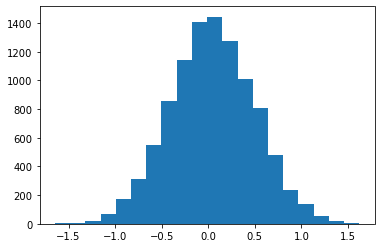

In [12]:
counts, bins, _ = plt.hist(all_vs,bins=20)

And we can test the code using a fit to a normal distribution using `scipy.stats.norm`:

In [13]:
from scipy.stats import norm

mean,std = norm.fit(all_vs)

if np.abs(mean) < 0.05:
    print("Test passed!")
else:
    print("Test failed!")
    
if np.abs(std - np.sqrt(2*params['gamma']*params['kT']/m[0])*params['dt']) < 0.01:
    print("Test passed!")
else:
    print("Test failed!")
    
print("The data fits to a normal distribution with mean", mean, "and width", std)


Test passed!
Test passed!
The data fits to a normal distribution with mean 0.043110350344429546 and width 0.45098374346108183


**Are these results expected?  Why or why not?**

/ your answer here /

## Simulation manager

We're all ready to run some simulations!  First let's make things a little easier on ourselves by defining a simulation manager.  This will be a function that takes in initial positions, velocities, masses, an integrator and a set of parameters, and returns a trajectory. 

In [14]:
def sim_manager(init_pos, init_vel, m, force_fn, integrator, params):
    """
    init_pos : initial positions 
    np.array, shape = (N,ndim)
    
    init_vel : initial velocities 
    np.array, shape = (N,ndim)
    
    m : masses
    np.array, shape = (N)
    
    force_fn : force function
    callable function that takes in x, returns a np.array with same shape
    
    integrator : integrator function
    callable function that takes in x, v, m, force_alg, params

    params : parameter dict
    dict (must contain dt, gamma, kT [floats], 
          n_steps, report_freq [integers])
    """
    
    # define empty arrays for (periodically) saving x and v
    n_steps = params['n_steps']
    report_freq = params['report_freq']
    
    n_reports = int(n_steps/report_freq) + 1
    
    N = init_pos.shape[0]
    ndim = init_pos.shape[1]
    
    traj_x = np.zeros((n_reports, N, ndim))
    traj_v = np.zeros((n_reports, N, ndim))
    
    current_x = init_pos
    current_v = init_vel
    
    for step in range(n_steps):
        
        current_x, current_v = integrator(current_x, current_v, m, force_fn, params)
        
        if step % report_freq == 0:
            # time to report
            report_idx = int(step/report_freq)
            traj_x[report_idx] = current_x
            traj_v[report_idx] = current_v
            
    return traj_x, traj_v

**Run three trajectories starting at x=0, v=0:**

In [15]:
params = {'dt' : 0.01,
         'gamma' : 1.0,
         'kT' : 100,
          'n_steps' : 10000,
          'report_freq' : 100
         }

all_trajs = []
n_traj = 3
for i in range(n_traj):
    print("Running trajectory",i+1,"of",n_traj)
    pos_traj, _ = sim_manager(np.array([[0.]]),
                              np.array([[0.]]),
                              np.array([1.]),
                              force,
                              VV_langevin,
                              params)
    all_trajs.append(pos_traj)

Running trajectory 1 of 3
Running trajectory 2 of 3
Running trajectory 3 of 3


**Here's a nice plot of our trajectories, along with the potential:**

In [16]:
def traj_plot(traj_list,x_vals,potential,n_steps):
    fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(4,8),sharex=True)
    for i, traj in enumerate(traj_list):
        ax[0].plot(traj[:,0,0],np.linspace(0,int(n_steps),pos_traj.shape[0]), label=f"Traj {i+1}")
        
    ax[0].set_ylabel("Time")
    ax[0].legend()

    ax[1].plot(x_vals,potential(x_vals))
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("U(x)")

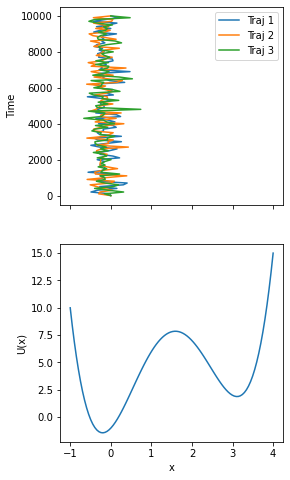

In [17]:
traj_plot(all_trajs,x_vals,potential,params['n_steps'])

**Run this again, using a larger number of trajectories and a larger number of steps.  What is happening here?  Why?**

/your answer here/

**Try starting at `x=3` instead.  Run a set of trajectories below and describe their behavior.**

In [18]:
# your code here

/your description here/

## Free energy plots

A great way to analyze your trajectories is to show the probability of visiting a given value of $x$, which we denote $P(x)$.  Probabilities are in the range $[0,1]$, but sometimes it can be difficult to see the probabilities of rarely visited states in your trajectory when the probability is plotted directly.

For this reason it is customary to instead plot $f(x) = -\log(P(x))$.

Since $x$ is continuous, we can first use the `np.histogram` function to bin it.  Let's use the `all_trajs[0]` array for an example:

In [20]:
counts, bins = np.histogram(all_trajs[0],bins=20)
cent_bins = 0.5*(bins[1:] + bins[:-1])  # get the center of each bin


Now the probability can be computed using the counts:

In [21]:
P = counts/counts.sum()

And the `f` can be computed using `np.log`, although since $\log(0) \rightarrow \infty$, we need to handle the non-zero values appropriately:

In [22]:
# the "where" argument only computes the log where the P values are greater than 0
f = -params['kT']*np.log(P,where=P>0)

# the P>0 is a "mask" used to select only the values of f where P > 0
f -= f[P>0].min()

fmax = 10000
# again, we use a P==0 mask to select only elements of f where P = 0, 
# and then we set those to fmax
f[P==0] = fmax

This `f` array is actually the **free energy of the system in units of `kT`**. This can be plotted along with the potential as follows:

Text(0, 0.5, 'Free energy (kT)')

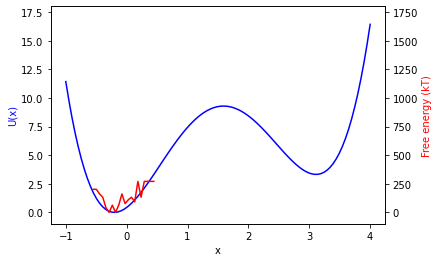

In [23]:
zeroed_potential = potential(x_vals)
zeroed_potential -= zeroed_potential.min()

fig, ax = plt.subplots(1,1)
ax.plot(x_vals,zeroed_potential, color='blue',label='U(x)')
ax.set_xlabel('x')
ax.set_ylim([-1,18])  # set the same range of y-values
ax.set_ylabel('U(x)',color='blue')

ax2 = ax.twinx()
ax2.plot(cent_bins[f < fmax], f[f < fmax], color='red', label='Free energy (kT)')
ax2.set_ylim([-100,1800]) # set the same range of y-values
ax2.set_ylabel('Free energy (kT)',color='red')

If we want to **combine multiple trajectories together**, we can't just average the free energy!  Instead we need to **average the probabilities**, or, equivalently, just **sum the counts**.  Let's make a function that does this:

In [24]:
def free_energy(coord_list, kT, nbins=20, fmax=10000):
    # get global min and max
    c_min = np.array(coord_list).min()
    c_max = np.array(coord_list).max()
    
    # define a total counts array
    tot_counts = np.zeros((nbins))
    
    for coord in coord_list:
        counts, bins = np.histogram(coord,bins=nbins,range=(c_min,c_max))
        tot_counts += counts
        
    cent_bins = 0.5*(bins[1:] + bins[:-1])  # get the center of each bin
    
    P = tot_counts/tot_counts.sum()

    f_nrg = -kT*np.log(P,where=P>0)

    f_nrg -= f_nrg[P>0].min()   # subtract the free energy minimum, so that
                   # the lowest value is zero

    f_nrg[P==0] = fmax # for all unvisited bins, assign them the maximum
                   # free energy
    
    return cent_bins, f_nrg, P

And use it to plot a **global** free energy distribution for the whole `all_trajs` list:

Text(0, 0.5, 'Free energy (kT)')

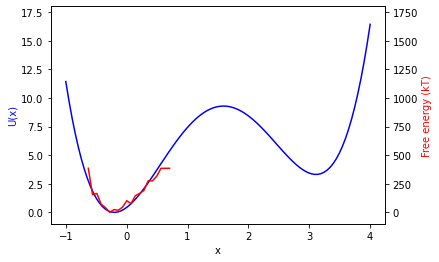

In [25]:
bins, f, P = free_energy(all_trajs, params['kT'])

fig, ax = plt.subplots(1,1)
ax.plot(x_vals,zeroed_potential, color='blue',label='U(x)')
ax.set_xlabel('x')
ax.set_ylim([-1,18])  # set the same range of y-values
ax.set_ylabel('U(x)',color='blue')

ax2 = ax.twinx()
ax2.plot(bins[f < fmax], f[f < fmax], color='red', label='Free energy (kT)')
ax2.set_ylim([-100,1800])  # set the same range of y-values
ax2.set_ylabel('Free energy (kT)',color='red')

## Turning up the heat

To finish off our lab today, **run sets of 10 trajectories (starting at `x=0`, each with 50000 steps, for each `kT` value in the following list: `100, 150, 200, 250, 300`.**

Save each trajectory set separately, then plot their `P(x)` curves (averaged over all the trajectories in the set).  Set the `plt.yscale('log')` and make sure to mask out the `P=0` values!

In [26]:
# your code here